<a href="https://colab.research.google.com/github/Anam2291/Deep_Learning_Projects/blob/main/Lung_Cancer_Detection_using_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<center>Lung Cancer Detection using VGG16 | Image Classification using Transfer Learning</center></h1>**

In [38]:
#importing libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.applications import vgg16
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [3]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 99% 1.75G/1.76G [00:07<00:00, 310MB/s]
100% 1.76G/1.76G [00:07<00:00, 241MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
data_dir = '/content/LungCancer'  # base_dir
CATEGORIES = ['lung_adenocarcinomas', 'lung_normal', 'lung_squamous_cell_carcinomas']



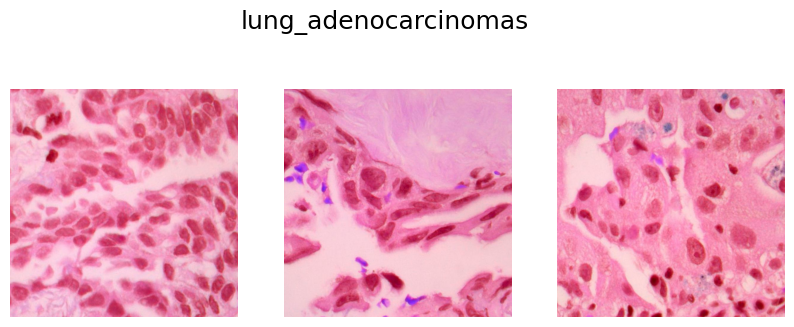

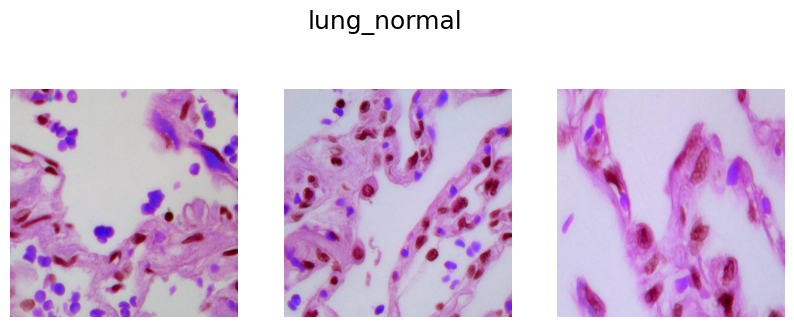

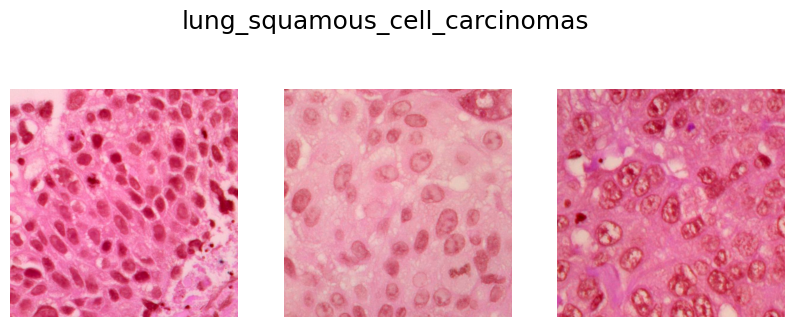

In [6]:
# Displaying the images
for category in CATEGORIES:
    path = os.path.join(data_dir, category)  # Constructing the path
    images = os.listdir(path)  # Extracting images from this particular path

    # Initialize a subplot with 1 row and 3 columns
    fig, ax = plt.subplots(1, 3, figsize=(10, 4)) # Subplot axes are managed using the ax array, making it more flexible and intuitive.
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        # Randomly select an image
        img_name = images[np.random.randint(0, len(images))] # Extracting any 3 random images from the entire range
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path) # To read the image data

        # Display the image
        ax[i].imshow(img_array) # Passing the data of images with the help of which display images
        ax[i].axis('off')





In [7]:
img_array.shape

(768, 768, 3)

**Converting Image into 224 Pixels**

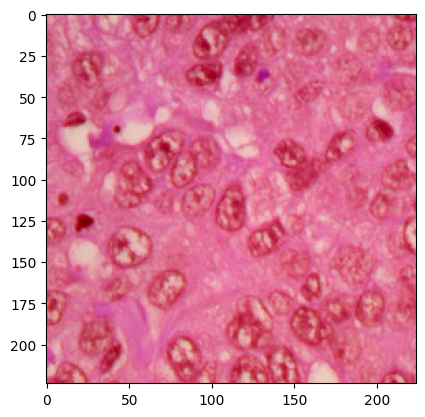

In [8]:
IMG_SIZE = 224
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)

In [9]:
new_array.shape

(224, 224, 3)

**Creating Training Data**

In [10]:
training_data = []    # Initializing training_data
def create_training_data():  #  Defining the Function
  for category in CATEGORIES:
    path = os.path.join(data_dir, category)  # data_dir: The root directory where the dataset is stored.
    labels = CATEGORIES.index(category) # class_num: The index of the current category in the CATEGORIES list, used as the label for that category.
    for img in os.listdir(path):   # Looping Through Images
      try:
        img_array = cv2.imread(os.path.join(path, img)) # Reads the image from the specified path as a NumPy array using OpenCV
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # Resizes the image to a uniform size (IMG_SIZE x IMG_SIZE).
                                              # This is crucial for feeding the data into a neural network, which requires consistent input dimensions.
        training_data.append([new_array, labels]) # Adds the resized image and its label as a pair to the training_data list.
      except Exception as e:  # Ensures that the loop continues even if an image cannot be read or resized due to errors (e.g., corrupted files).
        pass

create_training_data()


In [11]:
len(training_data)

15000

**Splits the preprocessed training_data** into two separate lists: one for the **features (X)** and the other for the **labels (y)**

**training_data: Contains pairs of images and labels, where each element is structured as [image_array, label].**

In [12]:
# Initializing Empty Lists
X = []          # X: Will store the image data (features).
y = []          # y: Will store the corresponding labels (targets/classes).

for features, labels in training_data:
  X.append(features)    # X.append(features): Adds the image data to the X list.
  y.append(labels)      # y.append(label): Adds the label to the y list.

In [13]:
type(X), type(y)

(list, list)


**Converting the data type of X and y from list to numpy array**

In [14]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)    # -1: Automatically infers the number of samples (i.e., the first dimension of the array).
                                                   # last value '3' for 'RGB'
y = np.array(y)   # Converts the Python list y (containing class labels) into a NumPy array.


In [15]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

#train-test split

In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = 0.2,
                                                  random_state = 42)

In [17]:
print(f'X_train Length : {X_train.shape[0]}, X_train Image size : {X_train.shape[1:3]}, Channel Dimension : {X_train.shape[3]}')
print(f'X_test Length : {X_test.shape[0]}, X_test Image size : {X_test.shape[1:3]}, Channel Dimension : {X_test.shape[3]}')


X_train Length : 12000, X_train Image size : (224, 224), Channel Dimension : 3
X_test Length : 3000, X_test Image size : (224, 224), Channel Dimension : 3


# Initializes a pre-trained VGG16 model from Keras

**The VGG16 model acts as a feature extractor for input images.**

**The feature maps will be passed to custom layers (e.g., dense or fully connected layers) to train the model on your dataset.**

In [18]:
vgg = vgg16.VGG16(weights = 'imagenet', # weights='imagenet' Specifies that the model should load pre-trained weights from the ImageNet dataset.
                  include_top = False, # include_top=False Indicates that the fully connected (classification) layers
                                       # at the top of the VGG16 model should be excluded.
                  input_shape = (IMG_SIZE, IMG_SIZE, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Freezes the pre-trained VGG16 convolutional layers

   - The convolutional layers in VGG16 are pre-trained on the ImageNet dataset.
   - These layers have learned generic features such as edges, textures, and patterns, which are often applicable to a wide variety of images.
   - Freezing these layers preserves the pre-trained features and speeds up training.

- **Focus on Custom Layers:**

The model will only train the additional (custom) layers added on top, enabling it to adapt to your specific classification task (e.g., lung cancer classification).


In [19]:
# freezing the bottom (conv) layers
for layer in vgg.layers:
  layer.trainable = False


# Building the Top (Fully Connected) Layers

In [20]:
model = keras.Sequential([      # keras.Sequential is a linear stack of layers
    vgg, # Includes the pre-trained VGG16 model without the top classification layers (include_top=False).All convolutional and pooling layers act as a feature extractor.
    keras.layers.GlobalAveragePooling2D(),  # Global Average Pooling (reduces feature map size).
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(3, activation = 'softmax'), # 3:Number of neurons corresponds to the number of classes
                                                    # (e.g., 3 categories: lung adenocarcinoma, lung normal, lung squamous cell carcinoma).

])

# Compile the Model

In [21]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if labels are one-hot encoded
              metrics=['accuracy'])


# **Train the Model**

In [22]:
model.fit(X_train, y_train, epochs=5) # X_train : The input training data (features).
                                      # In this case, it’s a 4D NumPy array with dimensions:
                                      # (number of samples, IMG_SIZE, IMG_SIZE, 3) for RGB images

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 120ms/step - accuracy: 0.8740 - loss: 0.9500
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 69s 123ms/step - accuracy: 0.9709 - loss: 0.0801
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - accuracy: 0.9821 - loss: 0.0465
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - accuracy: 0.9866 - loss: 0.0362
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - accuracy: 0.9911 - loss: 0.0239


# Model Evaluation on the Test data

In [24]:
# evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - accuracy: 0.9608 - loss: 0.1530
Model Accuracy : 96.93333506584167


When we make use of VGG16 Pretrained Model we get very high Accuracy because it is trained on very large on very large amount of Images

In [25]:
model.predict(X_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step


array([[2.8462422e-26, 6.0851242e-30, 1.0000000e+00],
       [2.7412038e-13, 1.0000000e+00, 4.6352063e-21],
       [6.2622325e-09, 4.1333945e-13, 1.0000000e+00],
       ...,
       [3.6858924e-05, 4.6400173e-09, 9.9996316e-01],
       [4.2737428e-11, 7.0266220e-17, 1.0000000e+00],
       [7.6408887e-06, 7.1198387e-11, 9.9999237e-01]], dtype=float32)

In [26]:
np.argmax(model.predict(X_test))  # It will check the Index at which we are having the highest probabilistic value,that index will be our Label.

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step


2

In [28]:
pred = np.argmax(model.predict(X_test), axis = -1) # will getting series of prediction
pred

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step


array([2, 1, 2, ..., 2, 2, 2])

In [29]:
# True Labels
y_test[:5]

array([2, 1, 2, 0, 1])

In [32]:
# Model Prediction
pred[:5]

array([2, 1, 2, 0, 1])

**True Labels and the Predicted Labels are Exactly same which means the model is performing really very well as we are having Accuracy of 96.9%**

# **Classification_report**

In [33]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1037
           1       1.00      1.00      1.00       970
           2       0.92      0.99      0.96       993

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



**f1-score really good for every category,if there is drastic change in the f1-score then we can say we have an imbalanced Data set,precision and recall values are good too.**

# **Confusion Matrix**

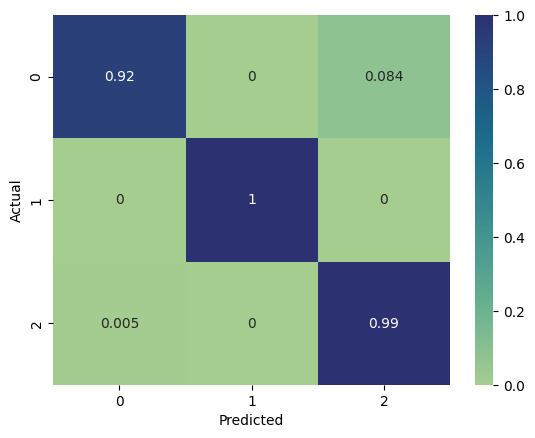

In [36]:
cf = confusion_matrix(y_test, pred,normalize= 'true') # normalize= 'true' as we want to display our values in percentage not in count.
sns.heatmap(cf, annot= True, cmap = 'crest')
plt.xlabel('Predicted');
plt.ylabel('Actual');

The Diagnol that is Dark Blue Squares are showing the percentage pf correct Classification Accuracy.

 Accuracy is Good,Model performing Good Predicting the values which are closer to the True Labels ,this how we make use of 'Pre-trained VGG16'model in order to build convolutional Neural Network